# Language Identification for Arabic and Tunisian Texts


**Steps:**
1. Read raw data
2. Clean data
3. Try existing language identification libraries
4. Construct our own dictionary-based language classifier
5. Construct our own language classifier using supervised learning



In [1]:
import pandas as pd
import numpy as np

In [2]:
from matplotlib import pyplot as plt
%matplotlib inline

# set the font size of plots
plt.rcParams['font.size'] = 14

In [3]:
np.set_printoptions(precision=3)

## Read raw data

In [5]:
corpus_files = ['data_TUN.txt', 'data_ARA.txt']

In [6]:
def read_text_file(filename):
    print('Reading file ' + filename + "...")
    with open(filename, "r", encoding='utf8') as textfile:
        L = []
        for line in textfile:
            L.append(line.strip())
        print('File contains ', len(L), "lines.\n")
        return L

In [7]:
tun_corpus = read_text_file(corpus_files[0])
ara_corpus = read_text_file(corpus_files[1])

Reading file langid_data_TUN-AR.txt...
File contains  13932 lines.

Reading file langid_data_ARA.txt...
File contains  21787 lines.



## Text Cleaning
For language identification, we usually only need to remove non-word characters and replace them with spaces. But since our corpus contains social media text, a few other operations are necessary.

- Remove non-word symbols (punctuation, math symbols, emoticons, URLs, hashtags, etc.).
- Replace punctuation and white space with a single space.
- Normalize word elongations and word repetitions.
- Remove documents that contain a large fraction of latin characters (some documents contain english or french words).
- Remove very short documents.

In [8]:
import re

# regexp for word elongation: matches 3 or more repetitions of a word character.
two_plus_letters_RE = re.compile(r"(\w)\1{1,}", re.DOTALL)
three_plus_letters_RE = re.compile(r"(\w)\1{2,}", re.DOTALL)
# regexp for repeated words
two_plus_words_RE = re.compile(r"(\w+\s+)\1{1,}", re.DOTALL)


def cleanup_text(text):
    # Remove URLs
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))', '', text)

    # Remove user mentions of the form @username
    text = re.sub('@[^\s]+', '', text)
    
    # Replace special html-encoded characters with their ASCII equivalent, for example: &#39 ==> '
    #if re.search("&#",text):
       # text = html.unescape(text)

    # Remove special useless characters such as _x000D_
    text = re.sub(r'_[xX]000[dD]_', '', text)

    # Replace all non-word characters (such as emoticons, punctuation, end of line characters, etc.) with a space
    text = re.sub('[\W_]', ' ', text)

    # Remove redundant white spaces
    text = text.strip()
    text = re.sub('[\s]+', ' ', text)

    # normalize word elongations (characters repeated more than twice)
    text = two_plus_letters_RE.sub(r"\1\1", text)

    # remove repeated words
    text = two_plus_words_RE.sub(r"\1", text)

    return text

# unit test of this function
cleanup_text("This is just a simple. js .... jshd)jhsd__js--dh \n\n asjh\n test !!")

'This just a simple js jshd jhsd js dh asjh test'

In [9]:


##1. Clean up each document in the corpus using the ``cleanup_text`` function given above.:    
tun_corpus_clean= [cleanup_text(doc) for doc in tun_corpus]
ara_corpus_clean= [cleanup_text(doc1) for doc1 in ara_corpus]
##2.  Remove all documents that contain a large fraction of latin characters
## Remove very short documents (containing less than 10 characters, for e.g.)
tun_corpus_clean_NLatin=[]

for doc in tun_corpus_clean:
     if(((len(" ".join(re.split('[^a-zA-Z]*',doc)))-1)/len(doc))*100 <70 and (len(doc)> 10)):
            tun_corpus_clean_NLatin.append(doc)
            
ara_corpus_clean_NLatin=[]
for doc in ara_corpus_clean:
     if(((len(" ".join(re.split('[^a-zA-Z]*',doc)))-1)/len(doc))*100 <70 and (len(doc)> 10)):
            ara_corpus_clean_NLatin.append(doc)
            
##3. Display the number of documents in the clean corpus:


tun_corpus_clean=  tun_corpus_clean_NLatin
ara_corpus_clean=  ara_corpus_clean_NLatin


print(len(tun_corpus_clean), len(ara_corpus_clean))

/anaconda3/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


12039 21293


### Load special libraries for language identification

In [11]:
# langdetect library
test_doc = "This is just a simple test !!"
import langdetect
from langdetect.lang_detect_exception import LangDetectException

try:
    res = langdetect.detect_langs(test_doc)   # LANGDETECT
    #res = langdetect.detect(test_doc) 
except LangDetectException:
    res = langdetect.language.Language("UNK",0)
res

[en:0.999995950061144]

In [12]:
# langid library

from langid.langid import LanguageIdentifier, model
li = LanguageIdentifier.from_modelstring(model, norm_probs=True)
print(li.classify(test_doc)[0])
# print(li.rank(test_doc)[0:3])

en


In [13]:
# NLTK textcat library - JUST IN CASE
from nltk.classify.textcat import TextCat

# create class instance
tc = TextCat()
tc.guess_language(test_doc)

'eng'

### Test ``langdetect`` on a small sample of Tunisian Corpus

In [14]:
# Select a small random sample of 5000 documents from the corpus
n = 5000
random_indices = np.random.choice(np.arange(len(tun_corpus_clean)), n, replace=False)
small_corpus = [tun_corpus_clean[i] for i in random_indices]

In [15]:
res_langdetect = []

for doc in small_corpus:
    try:
        res_langdetect.append(langdetect.detect_langs(doc))
    except LangDetectException:
        res_langdetect.append([langdetect.language.Language("UNK",0)])

In [16]:
len(small_corpus),len(res_langdetect)


(5000, 5000)

### Visualize results

In [17]:
# Let's put the results in a data frame for ease of manipulation

def foo1(x):
    u = str(x).split(':')
    return [u[0],float(u[1])]
L = [[small_corpus[i]]+foo1(x[0]) for i,x in enumerate(res_langdetect)]
df = pd.DataFrame(L)
df.columns = ['document', 'language','probability']
df.head()

,document,language,probability
0,حلوة شار مانت,ar,0.999996
1,قمة العارر بلاد تقاوم فالارهاب و ذكوررا تلوج ع...,ar,0.999998
2,كلامو معقول ان شاء الله ربي يحفظ بلادي تونس لع...,ar,0.999999
3,حاشه خليقة ربي هالصباح خنافرو كي خنافر البهيم ...,ar,0.999997
4,بحبوح و ياسر متربي و ربي يوفقك واصل,ar,0.999995


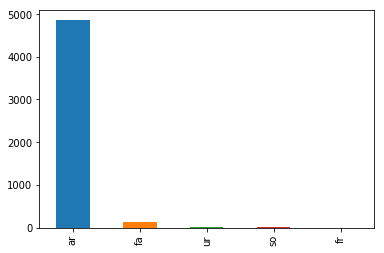

In [18]:
# The distribution of languages
df.language.value_counts().plot(kind="bar")


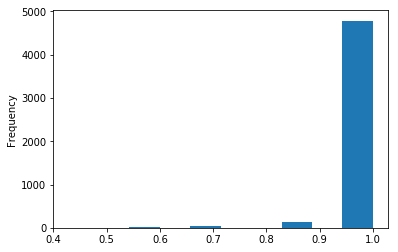

In [19]:
#Plot the histogram of probabilities:
df.probability.plot(kind="hist")


In [20]:
n = 5000
random_indices = np.random.choice(np.arange(len(ara_corpus_clean)), n, replace=False)
small_corpus = [ara_corpus_clean[i] for i in random_indices]
res_langdetect = []
 
for doc in small_corpus:
    try:
        res_langdetect.append(langdetect.detect_langs(doc))
    except LangDetectException:
        res_langdetect.append([langdetect.language.Language("UNK",0)])        
L = [[small_corpus[i]]+foo1(x[0])+[li.classify(small_corpus[i])[0],li.classify(small_corpus[i])[1]] for i,x in enumerate(res_langdetect)]
df1 = pd.DataFrame(L)
df1.columns = ['document', 'language_Langdetect','probability_langdetect','language_Langid', 'probability_langid']
df1.head()



,document,language_Langdetect,probability_langdetect,language_Langid,probability_langid
0,جيد جدا لا اظن انى محتاج عن سلسلة المحلات العا...,ar,1.000000,ar,1.000000
1,جهاز جميل جدا وموصفاته عاليه وبسعر بسيط بجد جه...,ar,0.999996,fa,0.991958
2,فندق ضعيف المستوى جدا انا نزلت انا وزوجتى فى ه...,ar,0.999998,ar,1.000000
3,Hisham Alghanim أحد أفضل الفنادق في القاهرة من...,ar,0.999999,ar,1.000000
4,افضل مكان لتسوق ايام عزايم بروح عليه عشان ما ا...,ar,1.000000,ar,1.000000


******

In [21]:
df1


,document,language_Langdetect,probability_langdetect,language_Langid,probability_langid
0,جيد جدا لا اظن انى محتاج عن سلسلة المحلات العا...,ar,1.000000,ar,1.000000
1,جهاز جميل جدا وموصفاته عاليه وبسعر بسيط بجد جه...,ar,0.999996,fa,0.991958
2,فندق ضعيف المستوى جدا انا نزلت انا وزوجتى فى ه...,ar,0.999998,ar,1.000000
3,Hisham Alghanim أحد أفضل الفنادق في القاهرة من...,ar,0.999999,ar,1.000000
4,افضل مكان لتسوق ايام عزايم بروح عليه عشان ما ا...,ar,1.000000,ar,1.000000
5,جنة الواحة لقد وصلنا إلى تلك المنشأة السنة الم...,ar,0.999996,ar,1.000000
6,جيد جدا وسعره ممتاز,ar,0.571428,fa,0.996742
7,قبل 9 شهور احسن فندق انا سكنت فيه لمدة تقارب ا...,ar,0.999997,ar,1.000000
8,قريب جدا من الحرم الفندق قريب جدا من الحرم بوا...,ar,0.999998,ar,1.000000
9,شكرا للوقت الرائع في الحقيقة احب ان اشكر جميع ...,ar,0.999999,ar,1.000000


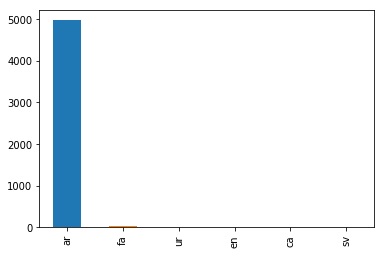

In [22]:
df1.language_Langdetect.value_counts().plot(kind="bar")

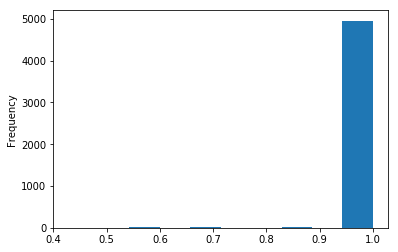

In [23]:
df1.probability_langdetect.plot(kind="hist")

## Construct a dictionary-based language classifier
- **Step 1**: Divide each corpus into a training corpus (70%) and test corpus (30%).
- **Step 2**: learn a set of typical words (also called stop words) of **every language** (TUN and ARA) based on its training corpus.
- **Step 3**: create a language identification algorithm that takes the list of typical words of each language and a new document as input; and returns the language of this document as output.
- **Step 4**: Evaluate the performance of this algorithm based on the test corpus -- calculate classification accuracy, precision, recall, F1, and confusion matrix.

In [24]:
from sklearn.model_selection import train_test_split


tun_corpus_clean_train, tun_corpus_clean_test = train_test_split(tun_corpus_clean,test_size=0.3 )

ara_corpus_clean_train, ara_corpus_clean_test = train_test_split(ara_corpus_clean,test_size=0.3)


In [25]:
ara_corpus_clean_test

['استراحة شاملة رائعة كليا كانت هذه زيارتنا الثانية إلى تيتانيك ديلوكس بيليك بعد أن زرناها في وقت سابق ليوم واحد في جولة عبر وكالة أسفار حصلنا على عطلة رائعة و فخمة مع الطعام الرائع خدمة رائعة و أشعة الشمس على الرغم من أننا ذهبنا في 18 أكتوبر كان خارج الموسم كانت غالبية إقامتنا لـ 4 ليال رائعة للغاية وكانت السلبية الوحيدة أن الغرف كان يمكن أن تكون أكثر نظافة وجدنا الشعر في الحمام و أحيانا حتى أكواب الشاي الفارغة تركت لمدة 2 أيام دون تنظيفها أو تغييرها وكانت عملية الحجز للمطاعم سهلة جدا و لم تكن هناك أي رسوم بـ 10 عند زياراتنا إلى المطعم الإيطالي أو مطعم السمك وكان الشيء الوحيد المخيب للآمال أنه في 4 ليال فقط كان لدينا وقت محدود و الأشخاص الذين يقومون بالحجز لم يقولوا لنا أنه لا يمكن أن يتم الحجز إلا في أوقات معينة على مدار اليوم أو أنه في بعض الليالي يكون البعض منها مغلقا لذلك غبنا عن بعضها عليك دفع ثمن الخمر في المطاعم و حتى أني رأيت 2 من الضيوف و قد أخذت منهم المشروبات لدى وصولهم حاملين لأكواب من النبيذ اخترنا مجرد الحصول على المشروبات الغازية بدلا من دفع اضافة الطعام في جميع المواقع

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
P = 1000   ## configuration hyperparameter

## Find typical words of the TUN language

# create TfidfVectorizer instance 
bow_model_tun = TfidfVectorizer (max_df = 1.0, min_df = 0.001)

# call fit() method with our TUN corpus; this will create the vocabulary of the corpus ...
bow_model_tun.fit( tun_corpus_clean_train )

# select P words from this vocabulary that have the SMALLEST IDF values
print(len(bow_model_tun.get_feature_names ()))
tfidf_vocab=bow_model_tun.get_feature_names ()

typical_words_tun =pd.DataFrame(dict(Word=tfidf_vocab,IDF=bow_model_tun.idf_)).sort_values("IDF", inplace=False, ascending = True ).head(1000)


## Find typical words of the ARA language

# call fit() method 
bow_model_ara = TfidfVectorizer (max_df = 1.0, min_df = 0.001)
bow_model_ara.fit( ara_corpus_clean_train )

# select P words from this vocabulary that have the SMALLEST IDF values 
print(len(bow_model_ara.get_feature_names ()))
tfidf_vocab=bow_model_ara.get_feature_names ()

typical_words_ara =pd.DataFrame(dict(Word=tfidf_vocab,IDF=bow_model_ara.idf_)).sort_values("IDF", inplace=False, ascending = True).head(1000)

print(typical_words_ara)
print(typical_words_tun)


1478
6692
           IDF      Word
5397  1.469279        من
4335  1.638833        في
4126  1.959020       على
3116  2.045824       جدا
1694  2.124023    الفندق
4467  2.408682       كان
4586  2.421942        لا
5640  2.445863       هذا
4310  2.489823      فندق
4922  2.544568        ما
4513  2.575536        كل
5244  2.603818        مع
283   2.633954        أن
4469  2.646059      كانت
3488  2.662902      رائع
360   2.694901       إلى
3190  2.705553       جيد
4154  2.782677        عن
1649  2.827129     الغرف
5650  2.833404      هناك
4854  2.912852        لم
4346  2.981488       فيه
6286  3.007118      ولكن
5333  3.013629      مكان
4368  3.043208       قبل
5655  3.068898        هو
3310  3.110649       حيث
2713  3.112867        به
2620  3.159440       بعد
1042  3.161768      التي
...        ...       ...
3033  5.830396     تكييف
94    5.830396      أجمل
1886  5.838834   المحلية
6024  5.838834     وجميع
4723  5.838834       لكي
5465  5.838834    موجودة
6434  5.838834     ويمكن
1784  5.838834 

In [27]:
# write the algorithm for dictionary-based language identification. 
#   This algorithm selects the language that has the highest number of typical words in the input document.

def dict_langid(typical_words,doc):
    s=0
    l=doc.split(" ")
    for i in typical_words:
         if i in l:
                s=s+1
    k=len(doc.split(" "))
    float(s)
    Frac=float(s/k)                
    return Frac

# for each document in the test combined test corpus
dict_langid(["Hello"], "Hello Guys How  are you ")

ARAS=[]


ARA=typical_words_ara['Word'].tolist()
TUN=typical_words_tun['Word'].tolist()
print(dict_langid(ARA, doc))
print(dict_langid(TUN, doc))
for i in small_corpus:
    S=[]
    S.append(i)
    if (dict_langid(ARA, i)>dict_langid(TUN, doc)):
        S.append('ARA')
    else:
        S.append('TUN')
    ARAS.append(S)


0.4576271186440678
0.11864406779661017


In [28]:
pd.DataFrame(ARAS)

,0,1
0,جيد جدا لا اظن انى محتاج عن سلسلة المحلات العا...,ARA
1,جهاز جميل جدا وموصفاته عاليه وبسعر بسيط بجد جه...,ARA
2,فندق ضعيف المستوى جدا انا نزلت انا وزوجتى فى ه...,ARA
3,Hisham Alghanim أحد أفضل الفنادق في القاهرة من...,ARA
4,افضل مكان لتسوق ايام عزايم بروح عليه عشان ما ا...,ARA
5,جنة الواحة لقد وصلنا إلى تلك المنشأة السنة الم...,ARA
6,جيد جدا وسعره ممتاز,ARA
7,قبل 9 شهور احسن فندق انا سكنت فيه لمدة تقارب ا...,ARA
8,قريب جدا من الحرم الفندق قريب جدا من الحرم بوا...,ARA
9,شكرا للوقت الرائع في الحقيقة احب ان اشكر جميع ...,ARA


In [29]:
TUNIS=[]
for i in tun_corpus_clean:
    S=[]
    S.append(i)
    if (dict_langid(ARA, i)>dict_langid(TUN, doc)):
        S.append('ARA')
    else:
        S.append('TUN')
    TUNIS.append(S)
pd.DataFrame(TUNIS)

,0,1
0,ملا عار يا تونس,ARA
1,البرنامج مهواش عاالي بلكل الييتفرجوا عليه يلزم...,ARA
2,الله يا الله شنو هذا,ARA
3,دون تعليق علي الريق متاع التونسية,ARA
4,هذي انسانة فاشلة نجحت بالفساد لتعمل فيه ربي يهدي,TUN
5,ولاد الهجالة موش مفيدة,TUN
6,ماسط مااسط اكبر ممثل فاشل في تونس,ARA
7,قولولوا يزي من النفاق,ARA
8,تراباوو معادش تعديو تصاور العرا و القرا و قلة ...,ARA
9,قناتكم عملت الريحة,TUN


## Construct a language classifier using supervised learning
- **Step 0**: Divide each corpus into a training corpus (70%) and test corpus (30%).
- **Step 1**: Create a data frame called ``train_df`` that has two columns: 'document' and 'language'. The 'document' column contains the two corpora concatenated together. The values in the '' column should be 'TUN' and 'ARA'.  Repeat the same thing for the ``test_df``.
- **Step 2**: Convert the training documents into numeric feature vectors using the BOW-tfidf method with **character ngrams**.
- **Step 3**: Create a language classifier using Naive Bayes method (tfidf version).
- **Step 4**: Evaluate performance of this classifier based on the test corpus -- calculate classification accuracy, precision, recall, F1, and confusion matrix.

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
tun_corpus_clean_train, tun_corpus_clean_test = train_test_split(tun_corpus_clean,test_size=0.3 )
ara_corpus_clean_train, ara_corpus_clean_test = train_test_split(ara_corpus_clean,test_size=0.3)

In [31]:
# create data frame
train_df = pd.DataFrame({'document':[], 'language':[]})
test_df = pd.DataFrame({'document':[], 'language':[]})
# fill the language column
train_df.language = pd.Series(['TUN']*len(tun_corpus_clean_train) + ['ARA']*len(ara_corpus_clean_train))
test_df.language = pd.Series(['TUN']*len(tun_corpus_clean_test) + ['ARA']*len(ara_corpus_clean_test))

train_df.document = pd.DataFrame(tun_corpus_clean_train+ara_corpus_clean_train) 
test_df.document=pd.DataFrame(tun_corpus_clean_test+ara_corpus_clean_test)

train_df.head()
test_df.head()

,document,language
0,نموت عليكم امور جدية وخاصة الفكاهة نحبكم,TUN
1,هي الاقدر في عيون البهايم اللي يحبوها و يدافعو...,TUN
2,كيما برنامج احمر بالخط العريض بالضبط حتي الديك...,TUN
3,انت لمعلم و مورو منك نتعلم,TUN
4,ربي ينصرك ويحفظك للوطن,TUN


In [32]:
# verify that the number of rows in this data frame = sum of the number of documents in each corpus.  
assert(train_df.shape[0] == len(tun_corpus_clean_train) + len(ara_corpus_clean_train))
assert(train_df.shape[1] == 2)

In [33]:
assert((train_df.language.nunique() == 2) and (list(train_df.language.unique()) == ['TUN', 'ARA']))

In [34]:
#Convert the training documents into numeric feature vectors using the BOW-tfidf method with character ngrams.



n =3   # hyperparameter for of character ngrams

# Create an instance of TfidfVectorizer class with analyzer = 'char' so that it generates bag of characters and not bag of words
bow_model_char = TfidfVectorizer(analyzer='char', ngram_range=(1,n), max_df = 0.5, min_df=0.1 )
# Call fit method with the combined training corpus
bow_model_char.fit(list(train_df['document']))

# Create DTM matrix of the combined training corpus and test corpus

X=bow_model_char.transform(train_df.document)
Y=bow_model_char.transform(test_df.document)
X.shape

(23332, 651)

In [35]:
from sklearn.naive_bayes import MultinomialNB

nb_model = MultinomialNB()

nb_model.fit(X,list(train_df['language']))


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [36]:
# Test
nb_model.predict_proba(bow_model_char.transform(["الناس تكبر تعقال..و هذوما يكبرو يزيدو يخشوا الخلاء"]))

array([[0.247, 0.753]])

In [37]:
nb_model.score(X,list(train_df['language']))

0.9318961083490486

In [38]:
# Test
nb_model.predict(bow_model_char.transform(["الناس تكبر تعقال..و هذوما يكبرو يزيدو يخشوا الخلاء"]))

array(['TUN'], dtype='<U3')

In [39]:
nb_model.score(Y,list(test_df['language']))

0.9339

In [40]:

from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score



In [41]:
accuracy_score(test_df['language'],nb_model.predict(Y))

0.9339

In [42]:
confusion_matrix(test_df['language'],nb_model.predict(Y))

array([[6162,  226],
       [ 435, 3177]])

In [43]:
f1_score(test_df['language'],nb_model.predict(Y),average=None)

array([0.949, 0.906])

In [44]:
precision_score(test_df['language'],nb_model.predict(Y),pos_label='ARA')


0.9340609367894498